In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.set()

pd.options.display.max_columns = 50

## Data importing

### Download data

In [2]:
# from https://quarry.wmflabs.org/query/17277

!wget https://quarry.wmflabs.org/run/161838/output/0/tsv?download=true -O botvbot-enwiki-comments.tsv

--2017-03-12 15:41:36--  https://quarry.wmflabs.org/run/161838/output/0/tsv?download=true
Resolving quarry.wmflabs.org (quarry.wmflabs.org)... 208.80.155.156
Connecting to quarry.wmflabs.org (quarry.wmflabs.org)|208.80.155.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘botvbot-enwiki-comments.tsv’

botvbot-enwiki-comm     [          <=>       ]  52.44M  3.50MB/s    in 20s     

2017-03-12 15:41:56 (2.65 MB/s) - ‘botvbot-enwiki-comments.tsv’ saved [54992636]



### Import to pandas dataframe

In [3]:
df = pd.read_csv("botvbot-enwiki-comments.tsv", sep="\t", encoding="utf-8")

In [4]:
len(df)

162688

In [5]:
print(df.columns)

Index(['rev_id', 'rev_timestamp', 'rev_user', 'rev_user_text', 'rev_page',
       'rev_sha1', 'rev_minor_edit', 'rev_deleted', 'rev_parent_id',
       'archived', 'reverting_id', 'reverting_timestamp', 'reverting_user',
       'reverting_user_text', 'reverting_page', 'reverting_sha1',
       'reverting_minor_edit', 'reverting_deleted', 'reverting_parent_id',
       'reverting_archived', 'rev_revert_offset', 'revisions_reverted',
       'reverted_to_rev_id', 'page_namespace', 'page_title',
       'page_is_redirect', 'rev_comment'],
      dtype='object')


## Data processing
### Create field for deleted revisions

In [6]:
df['is_deleted'] = np.where(df.rev_comment.isnull(), 1, 0)
df['is_deleted'].value_counts()

0    158593
1      4095
Name: is_deleted, dtype: int64

### Create datetime index based on date of reverting edit

In [7]:
df['reverting_timestamp_dt'] = pd.to_datetime(df['reverting_timestamp'], format="%Y%m%d%H%M%S")
df = df.set_index('reverting_timestamp_dt')

### Create field for comment text with text in brackets and parentheses removed

In [8]:
# by http://stackoverflow.com/questions/14596884/remove-text-between-and-in-python

def remove_brackets(test_str):
    test_str = str(test_str)
    ret = ''
    skip1c = 0
    skip2c = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    return ret

In [9]:
df['rev_comment_nobracket'] = df['rev_comment'].apply(remove_brackets)

### Create second dataset for ns0 / articles only

In [10]:
df_ns0 = df[df['page_namespace'] == 0].copy()

## Exploratory analysis

### Most frequent comments in ns0 reverts, with text in brackets & parens removed

In [11]:
other_count = 0
for comment, count in df_ns0['rev_comment_nobracket'].value_counts().iteritems():
    if count > 25:
        print(count, "\t", comment)
    else:
        other_count = other_count + count
print(other_count, "\tOther cases")

32455 	 Robot: Fixing double redirect to 
17164 	  Migrating 1 interwiki links, now provided by  on 
10850 	 Bot: Fixing double redirect to 
3932 	 Robot: Fixing double redirect
3508 	  Migrating 2 interwiki links, now provided by  on 
2769 	 removing a protection template from a non-protected page 
1828 	  Migrating 3 interwiki links, now provided by  on 
1512 	 nan
939 	 Bot: Migrating 1 interwiki links, now provided by  on 
749 	 r2.7.3) 
712 	 removing non-applicable orphan template
604 	 Bot: Migrating 1 langlinks, now provided by Wikidata on 
559 	 Robot: moving pages out of redirected category
482 	 Daily update. See  for changes.
400 	 Robot: change redirected category  to 
394 	 : Fixing double redirect
386 	 r2.6.4) 
287 	 Robot - Moving category Super NES games to Super Nintendo Entertainment System games per  at .
286 	 r2.7.2+) 
232 	 robot Modifying: 
188 	 Robot - Moving category United Kingdom employment case law to  per  at .
185 	 r2.7.2) 
153 	 Robot - Speedily movin

## Categorizing types of bot activity based on comments

In [12]:
def comment_categorization(comment):
    
    comment = str(comment)
    
    if comment == 'nan':
        return "deleted revision"
    
    elif comment.find("Reverted edits by [[Special:Contributions/ImageRemovalBot") >= 0:
        return "botfight: 718bot vs ImageRemovalBot"
    
    elif comment.lower().find("double redirect") >= 0:
        return "fixing double redirect"
    
    elif comment.lower().find("double-redirect") >= 0:
        return "fixing double redirect"
    
    elif comment.lower().find("redirect tagging") >= 0:
        return "redirect tagging/sorting"
    
    elif comment.lower().find("sorting redirect") >= 0:
        return "redirect tagging/sorting"
    
    elif comment.lower().find("change redirected category") >= 0:
        return "category redirect cleanup"
    
    elif comment.lower().find("redirected category") >=0:
        return "category redirect cleanup"
    
    elif comment.find("[[User:Addbot|Bot:]] Adding ") >= 0:
        return "template tagging"
    
    elif comment.lower().find("interwiki") >= 0:
        return "interwiki link cleanup"
    
    elif comment.lower().find("langlinks") >= 0:
        return "interwiki link cleanup"
    
    elif comment.lower().find("moving category") >= 0:
        return "moving category"
    
    elif comment.lower().find("re-categorisation") >= 0:
        return "moving category"
    
    elif comment.lower().find("removing a protection template") >= 0:
        return "protection template cleanup"
    
    elif comment.lower().find("removing orphan t") >= 0:
        return "orphan template cleanup"
    
    elif comment.lower().find("non-applicable orphan") >= 0:
        return "orphan template cleanup"
    
    elif comment.lower().find("removed orphan t") >= 0:
        return "orphan template cleanup"    
    
    elif comment.lower().find("sandbox") >= 0:
        return "clearing sandbox"
    
    elif comment.lower().find("archiving") >= 0:
        return "archiving"
    
    elif comment.lower().find("duplicate on commons") >= 0:
        return "commons image migration"
    
    elif comment.lower().find("user:mathbot/changes to mathlists") >= 0:
        return "mathbot mathlist updates"
    
    
    #   Note: these interwiki links may be a bit broad. They have a country code following
    #   the first [[, but there are many country codes and I need a better way of searching
    #   for that.
    
    elif comment.lower().find("robot: adding [[") >= 0:
        return "interwiki link cleanup"
    
    elif comment.lower().find("robot: modifying [[") >= 0:
        return "interwiki link cleanup"
    
    elif comment.lower().find("robot: deleting [[") >= 0:
        return "interwiki link cleanup"  
    
    elif comment.lower().find("robot: removing [[") >= 0:
        return "interwiki link cleanup"      

    elif comment.lower().find("robot adding: [[") >= 0:
        return "interwiki link cleanup"
    
    elif comment.lower().find("robot modifying: [[") >= 0:
        return "interwiki link cleanup"
    
    elif comment.lower().find("robot deleting: [[") >= 0:
        return "interwiki link cleanup"  
    
    elif comment.lower().find("robot removing: [[") >= 0:
        return "interwiki link cleanup"      
    
    elif comment.lower().find("link syntax") >= 0:
        return "link syntax fixing"
    
    elif comment.lower().find("links syntax") >= 0:
        return "link syntax fixing" 
    
    else:
        return "other"

### Apply categorization

In [13]:
df['bottype'] = df['rev_comment'].apply(comment_categorization)
df_ns0['bottype'] = df_ns0['rev_comment'].apply(comment_categorization)

### Set type to "other redirect" for other cases on redirect pages

In [14]:
df.loc[(df['bottype'] == 'other') & (df['page_is_redirect'] == 1), ['bottype']] = 'other redirect'
df_ns0.loc[(df_ns0['bottype'] == 'other') & (df_ns0['page_is_redirect'] == 1), ['bottype']] = 'other redirect'

# Analysis
## Types of bot-vs-bot reverts across all namespaces

### Counts

In [15]:
df['bottype'].value_counts()

fixing double redirect                 55657
interwiki link cleanup                 55643
other                                  35620
deleted revision                        4095
protection template cleanup             2959
archiving                               2789
moving category                         2250
category redirect cleanup               1196
orphan template cleanup                  970
mathbot mathlist updates                 485
other redirect                           317
clearing sandbox                         228
redirect tagging/sorting                 204
botfight: 718bot vs ImageRemovalBot      173
link syntax fixing                        74
template tagging                          23
commons image migration                    5
Name: bottype, dtype: int64

### Percentages

In [16]:
df['bottype'].value_counts(normalize=True) * 100

fixing double redirect                 34.210882
interwiki link cleanup                 34.202277
other                                  21.894670
deleted revision                        2.517088
protection template cleanup             1.818819
archiving                               1.714324
moving category                         1.383015
category redirect cleanup               0.735149
orphan template cleanup                 0.596233
mathbot mathlist updates                0.298117
other redirect                          0.194851
clearing sandbox                        0.140146
redirect tagging/sorting                0.125393
botfight: 718bot vs ImageRemovalBot     0.106339
link syntax fixing                      0.045486
template tagging                        0.014137
commons image migration                 0.003073
Name: bottype, dtype: float64

### Plot

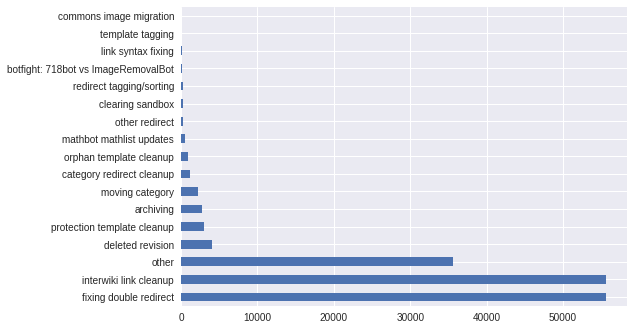

In [17]:
df['bottype'].value_counts().plot(kind='barh')

## Types of bot-vs-bot reverts in ns0 / articles

### Counts

In [18]:
df_ns0['bottype'].value_counts()

fixing double redirect                 49173
interwiki link cleanup                 26872
protection template cleanup             2769
deleted revision                        1512
moving category                         1351
category redirect cleanup                975
orphan template cleanup                  970
mathbot mathlist updates                 482
other                                    204
redirect tagging/sorting                 204
botfight: 718bot vs ImageRemovalBot      170
link syntax fixing                        70
other redirect                            26
template tagging                          23
commons image migration                    3
Name: bottype, dtype: int64

### Percentages

In [19]:
df_ns0['bottype'].value_counts(normalize=True)* 100

fixing double redirect                 57.984293
interwiki link cleanup                 31.687185
protection template cleanup             3.265176
deleted revision                        1.782935
moving category                         1.593085
category redirect cleanup               1.149710
orphan template cleanup                 1.143814
mathbot mathlist updates                0.568369
other                                   0.240555
redirect tagging/sorting                0.240555
botfight: 718bot vs ImageRemovalBot     0.200462
link syntax fixing                      0.082543
other redirect                          0.030659
template tagging                        0.027121
commons image migration                 0.003538
Name: bottype, dtype: float64

### Plot

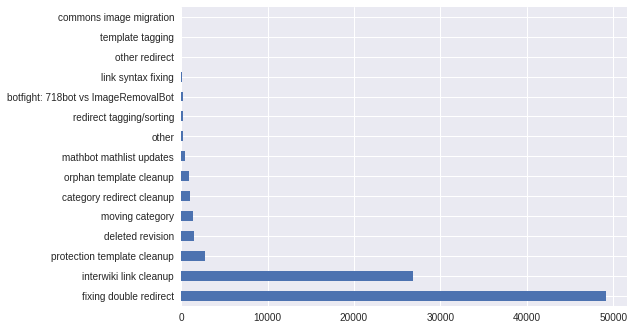

In [20]:
df_ns0['bottype'].value_counts().plot(kind='barh')

## Timeseries visualizations

### Group by daily counts for each bot type, all namespaces

In [21]:
gp = df.groupby([pd.TimeGrouper('1D', closed='left'), 'bottype'])

### Subplots by bot type, no shared y axis

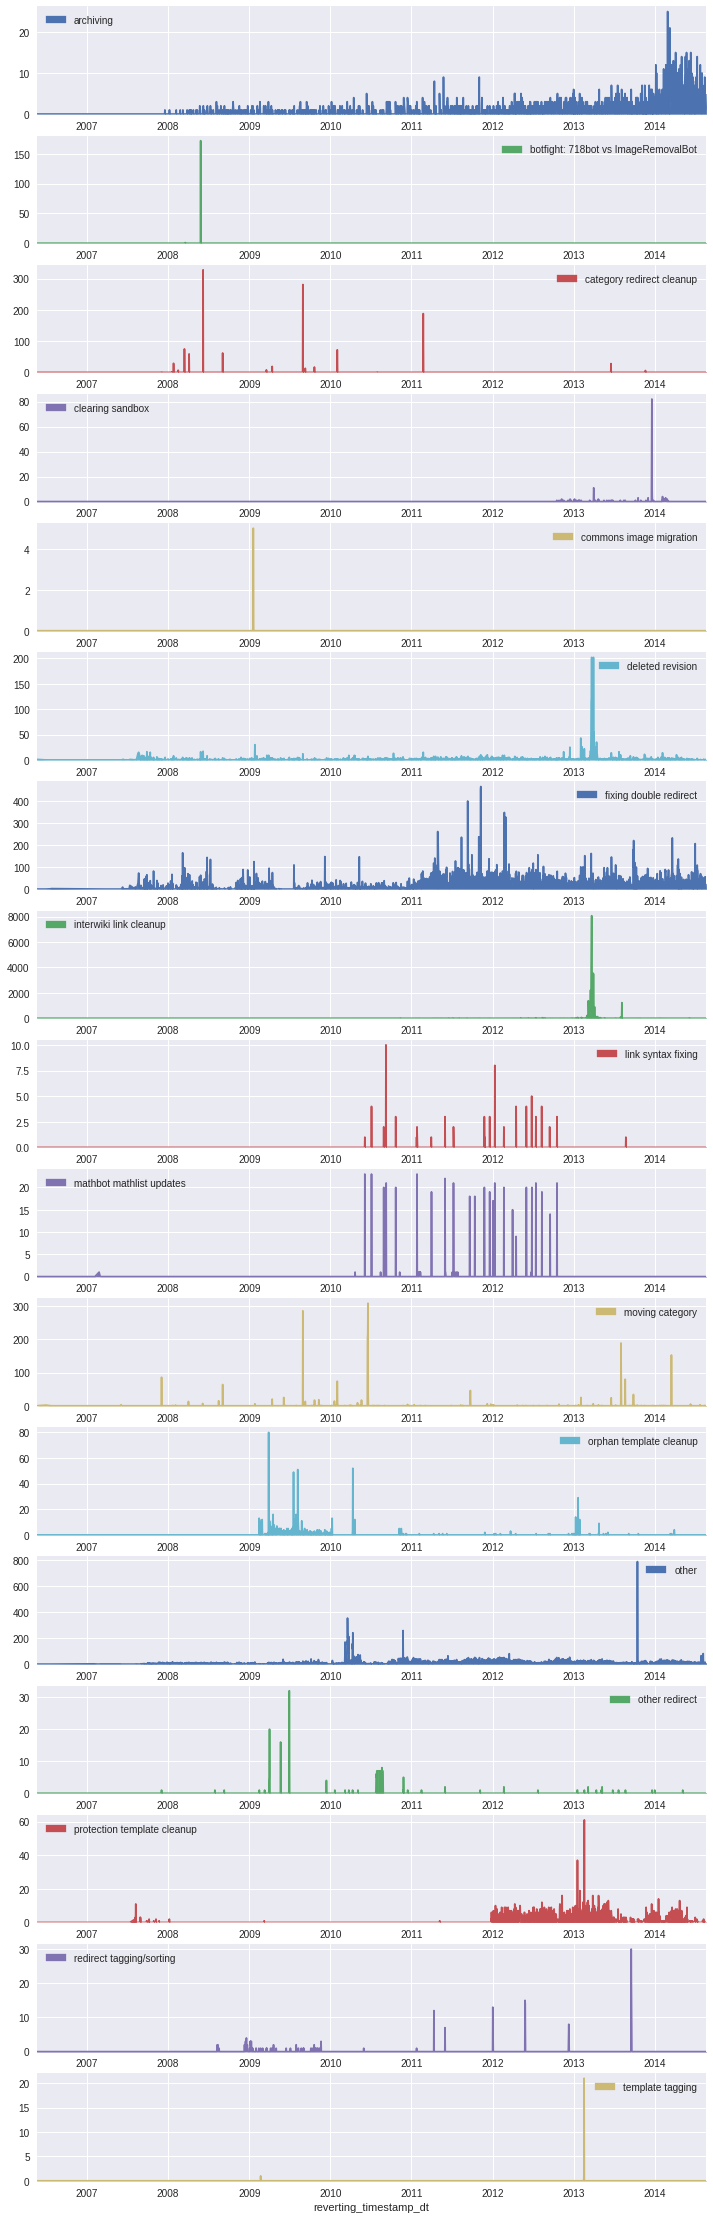

In [22]:
ax1 = gp.rev_id.count().unstack().plot(kind='area', subplots=True, figsize=[12,40], sharex=False)

### Subplots by bot type, shared y axis

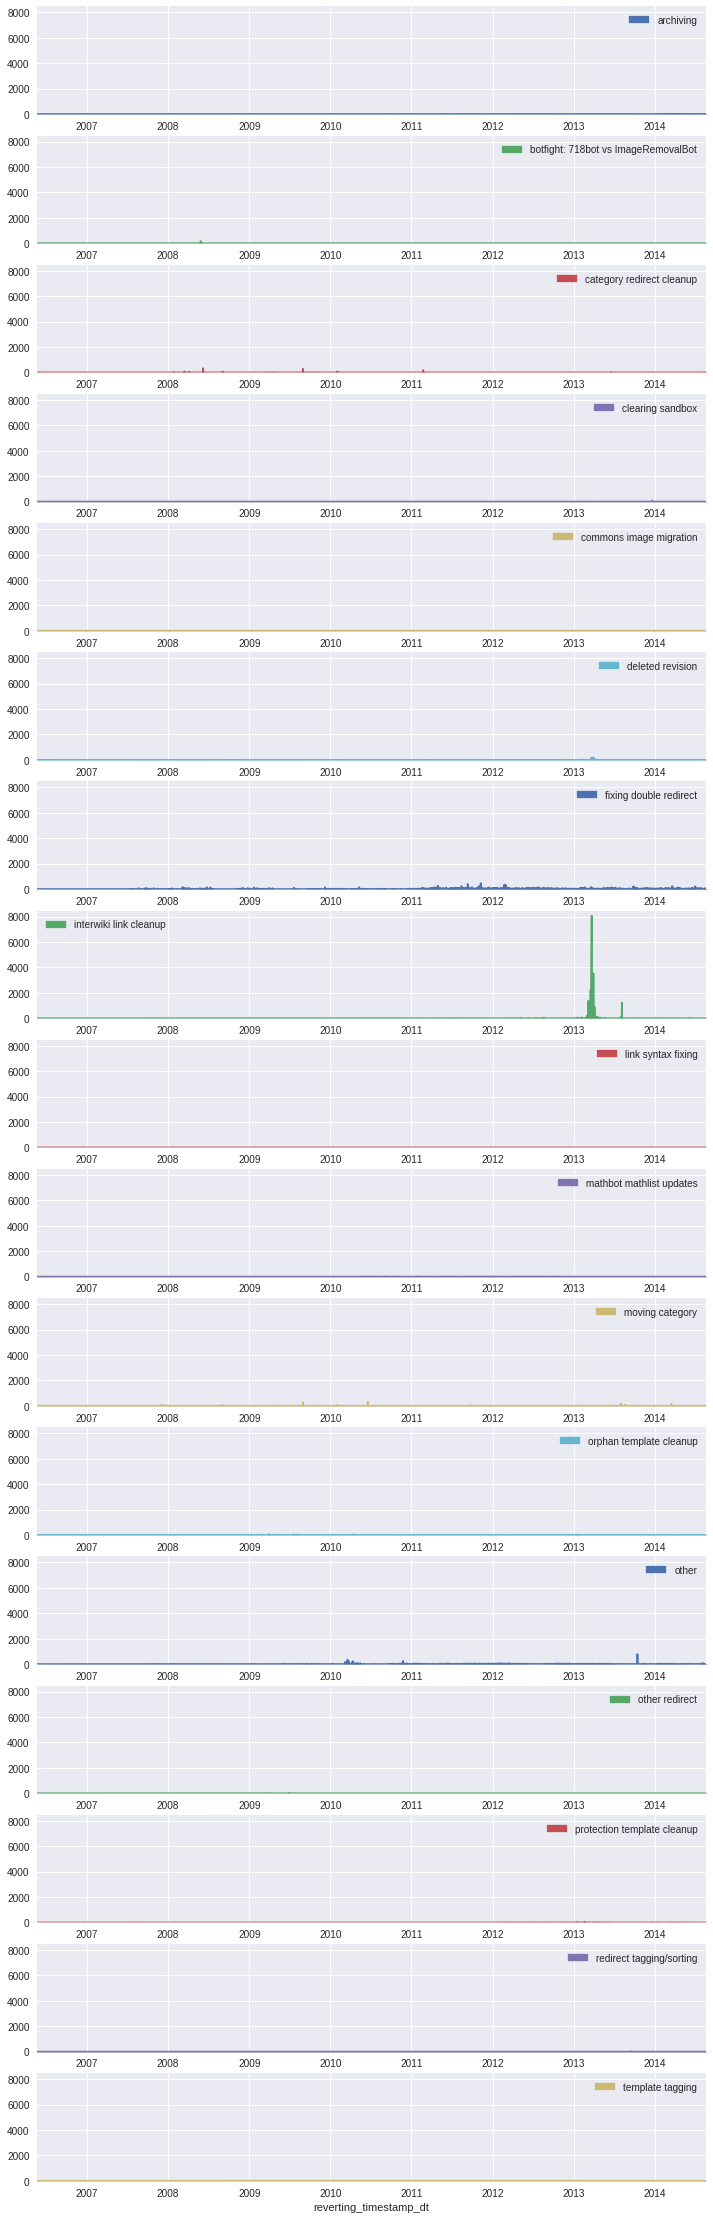

In [23]:
ax2 = gp.rev_id.count().unstack().plot(kind='area', subplots=True, figsize=[12,40], sharex=False, sharey=True)

### Group by daily counts for each bot type, ns0 / articles only

In [24]:
gp_ns0 = df_ns0.groupby([pd.TimeGrouper('1D', closed='left'), 'bottype'])

### Subplots by bot type, no shared y axis

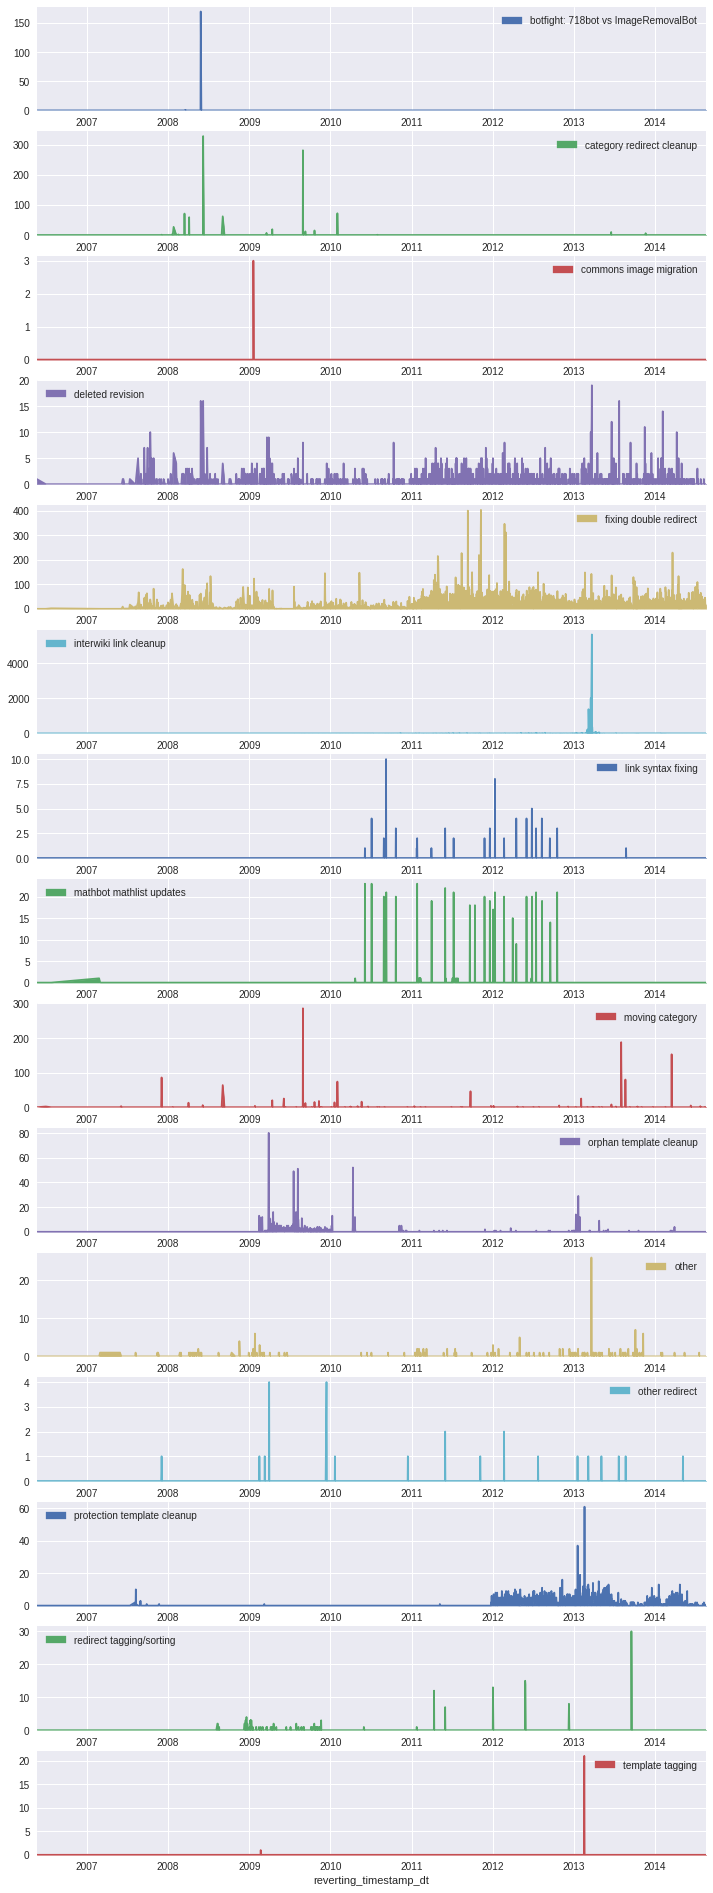

In [25]:
ax3 = gp_ns0.rev_id.count().unstack().plot(kind='area', subplots=True, figsize=[12,34], sharex=False)

### Subplots by bot type, shared y axis

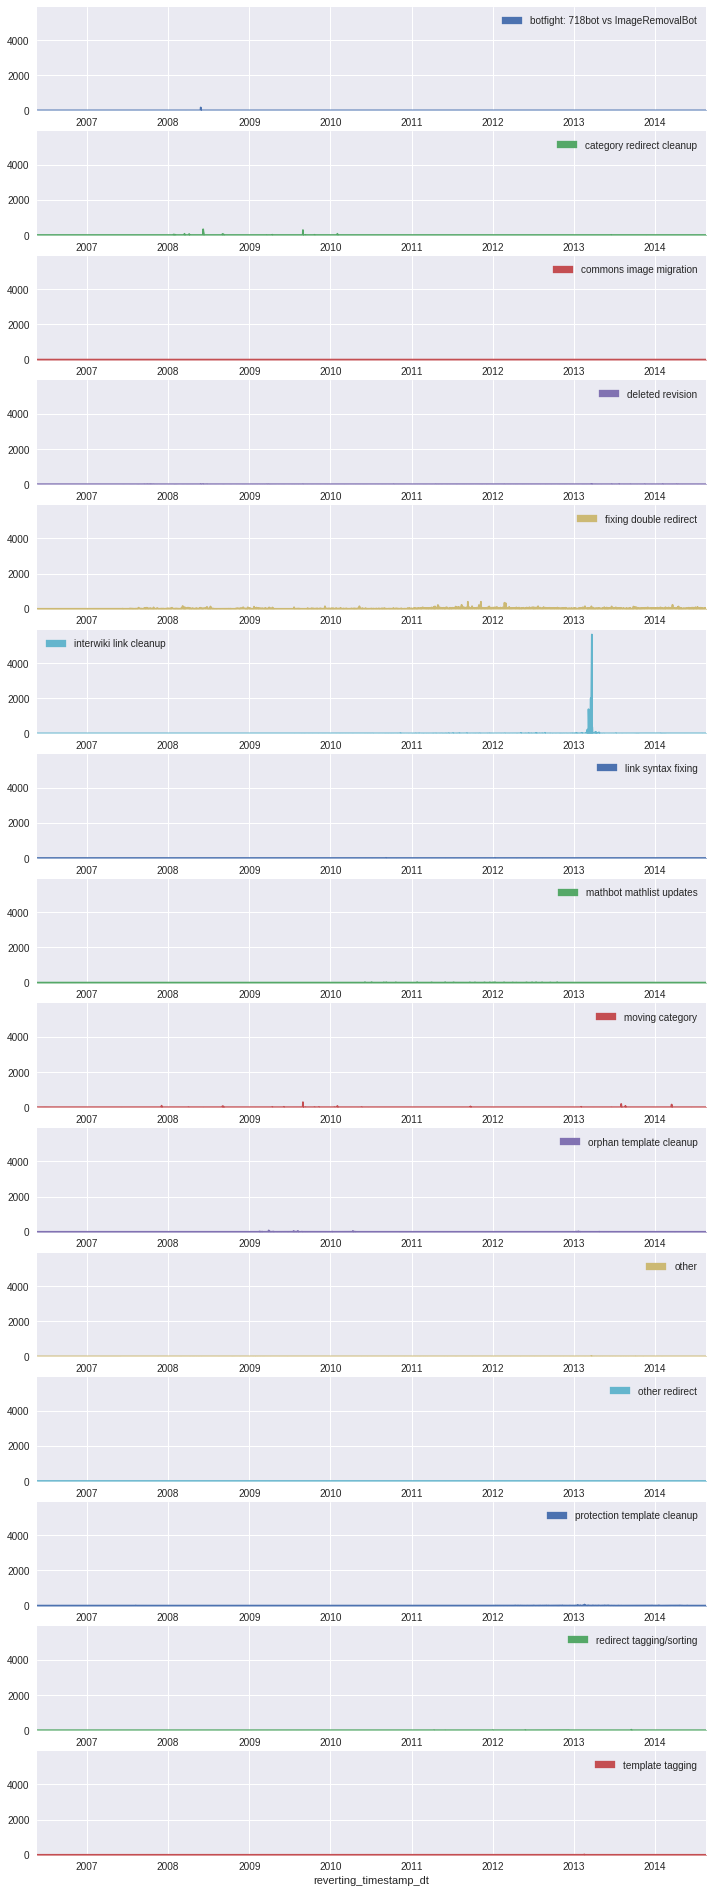

In [26]:
ax4 = gp_ns0.rev_id.count().unstack().plot(kind='area', subplots=True, figsize=[12,34], sharex=False, sharey=True)

## What wasn't categorized in ns0?

In [27]:
pd.options.display.max_rows = 1000
df_ns0[df_ns0['bottype'] == 'other'][['reverting_user_text', 'rev_user_text', 'rev_comment', 'page_is_redirect']]

,reverting_user_text,rev_user_text,rev_comment,page_is_redirect
reverting_timestamp_dt,,,,
2012-01-02 23:13:17,Yobot,Mathbot,[[WP:CHECKWIKI]] error fixes + [[WP:GENFIXES|g...,0.0
2011-02-02 02:22:07,Yobot,Mathbot,[[WP:CHECKWIKI]] error fixes + [[WP:GENFIXES|g...,0.0
2011-02-03 16:52:36,Yobot,Mathbot,[[WP:CHECKWIKI]] error fixes + [[WP:GENFIXES|g...,0.0
2011-02-04 01:39:39,Yobot,Mathbot,[[WP:CHECKWIKI]] error 61 fixes + [[WP:GENFIXE...,0.0
2011-02-06 12:23:52,Yobot,Mathbot,[[WP:CHECKWIKI]] error fixes + [[WP:GENFIXES|g...,0.0
2011-02-08 12:30:07,Yobot,Mathbot,[[WP:CHECKWIKI]] error fixes + [[WP:GENFIXES|g...,0.0
2011-02-10 12:13:53,Yobot,Mathbot,[[WP:CHECKWIKI]] error fixes + [[WP:GENFIXES|g...,0.0
2011-07-21 22:18:59,Yobot,Mathbot,[[WP:CHECKWIKI]] error 6|17|22|26|37|38|44|45|...,0.0
2012-01-02 23:14:21,Yobot,Mathbot,/* Xen */[[WP:CHECKWIKI]] error fixes + [[WP:G...,0.0


# Export

In [28]:
df.to_pickle("botvbot-enwiki-comments-allns-processed.pickle")
df.to_csv("botvbot-enwiki-comments-allns-processed.tsv", sep="\t")
df_ns0.to_pickle("botvbot-enwiki-comments-ns0-processed.pickle")
df_ns0.to_csv("botvbot-enwiki-comments-ns0-processed.tsv", sep="\t")